# TASK

Consider the large scale Twitter friendship dataset available at Twitter Friends (kaggle.com) of full
Twitter user profile data (40K users), including friendship relationship. We want to explore this
friendship relation to construct a network graph where User IDs are nodes and a directed edge from
IDx to IDy if IDy is listed as a friend of IDx.

1. Use NetworkX to display the corresponding network, suggest an approach to visualize this
dense network using visualization tool of your choice (NetworkX is not ideal for dense
graphs). Save the adjacency matrix of this graph in a separate file.
2. Write a script that uses NetworkX functions to calculate diameter, average clustering
coefficient and average path length of the network.
3. Write a script that plots the degree centrality distribution and closeness centrality
distribution.
4. We want to test the extent to which the centrality distributions in 3) fit a power law
distribution. You may inspire from the implementation in powerlaw · PyPI of the power-law
distribution, or can use alternative one of your choice. It is important to quantify the
goodness of fit using p-value. Typically, when p-value is greater than 10%, we can state that
power-law is a plausible fit to the (distribution) data.
5. Write a script that calculates the number of triangles in the network.
6. Write a script that identifies the largest strongly connected component, second largest, third
largest. Display each component (If there is more than one component for a given case,
then draw one at random).
7. Write a script that calculates the shortest distance between any pair of the strongly
connected components in 5). Present the result in a table. Comment on the separability
between the above components.
8. We want to identify relevant communities from the subnetwork graph corresponding to the
largest, second largest and third largest component. For this purpose, use Label propagation
algorithm implementation in NetworkX to identify the main communities. Write a script
that uses different color for each community and visualize the above graph with the detected
communities. Use the appropriate function in NetworkX to compute the separation among
the various communities and any other related quality measures. Comment on the quality of
the partition.
9. We want to evaluate the evolution of the triangles (transitivity relation in the network). For
this purpose, we consider time increment as an accumulation of one thousand successive
rows in the original dataset. Suggest a script that calculates the evolution of the proportion
of triangles (number of triangles over the total number of nodes up to time t, basically t=1,
2,…,40), and draws the corresponding graph.
10. From 9), write a script that identifies instances of triplet nodes A, B, C such at time t A is
connected to B and B is connected to C but A is not connected to C, while in time t+1, A
becomes connected to C. Check for theses instances whether the link prediction using
common neighbor (probability A being connected to C increases with the number of
common neighbours between A and B). Write the result in a table.
11. Suggest appropriate literature to comment on the various findings and explore the limitation
of the reasoning pipeline.

The data contains the following columns:
- avatar: URL to the profile picture
- followerCount: the number of followers of this user
- friendsCount: the number of people following this user
- friendName: stores the @name (without the '@') of the user (beware this name can be changed by the user)
- id: user ID, this number can not change (you can retrieve screen name with this service: https://tweeterid.com/)
- friends: the list of IDs the user follows (data stored is IDs of users followed by this user)
- lang: the language declared by the user (in this dataset there is only "en" (english))
- lastSeen: the time stamp of the date when this user have post his last tweet
- tags: the hashtags (with or without #) used by the user. It's the "trending topic" the user tweeted about
- tweetID: ID of the last tweet posted by this user

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy
import powerlaw
import pandas as pd

In [2]:
# open the csv file
with open('data.csv', 'r') as f:
    data = f.readlines()

# remove the first line
data = data[1:]

Number of nodes: 73671 Number of edges: 39981


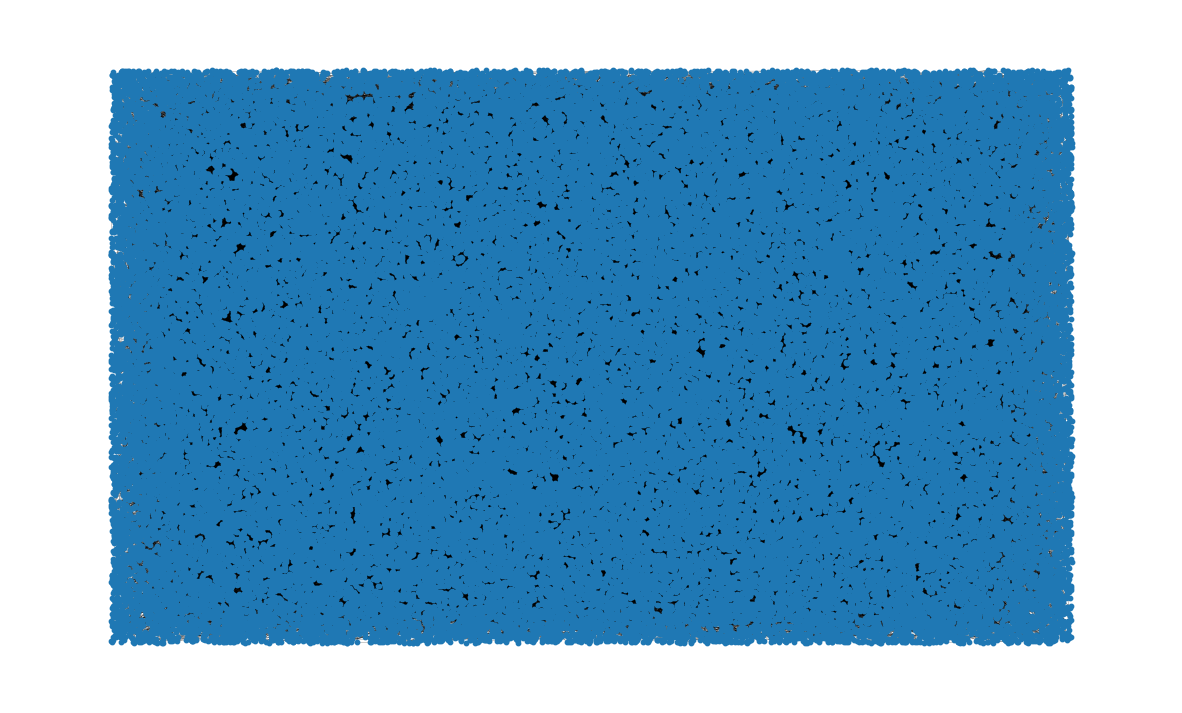

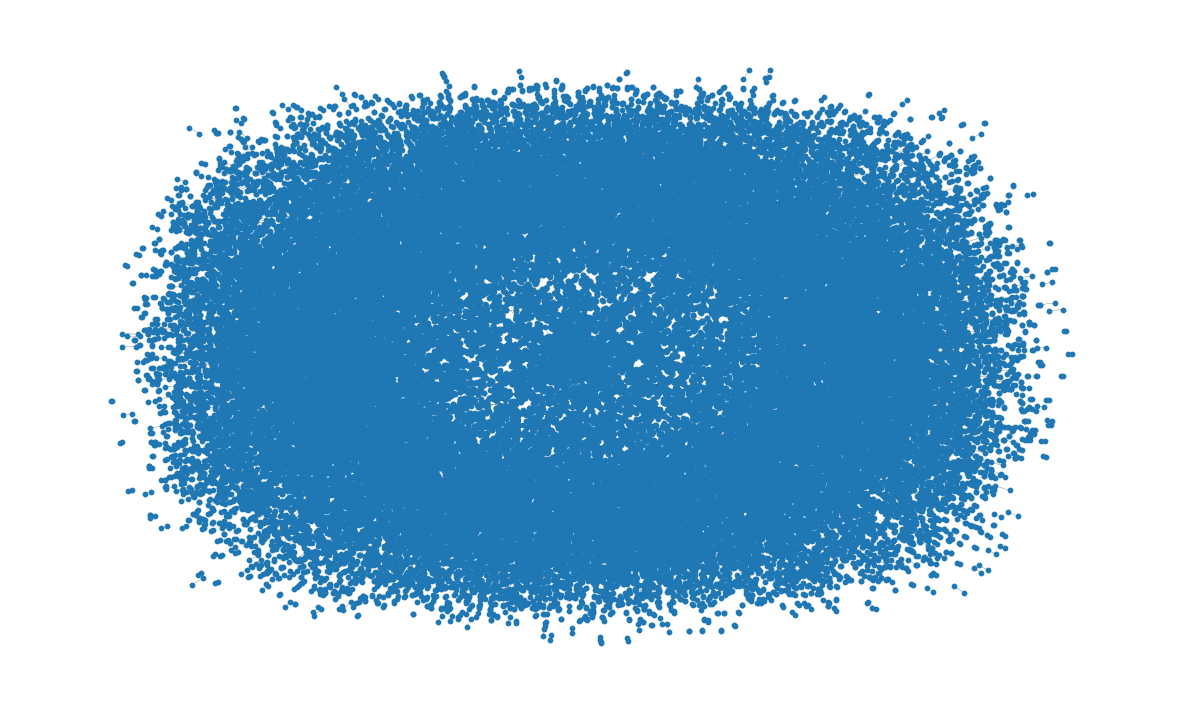

In [4]:
'''
1. Use NetworkX to display the corresponding network, suggest an approach to visualize this
dense network using visualization tool of your choice (NetworkX is not ideal for dense
graphs). Save the adjacency matrix of this graph in a separate file.

TODO: Alternative visualization
'''

def create_graph(data):
    G = nx.Graph()
    for line in data:
        line = line.strip().split(',')
        id = line[0].strip('"').strip()
        screenName = line[1].strip('" ')
        tags = line[2].strip('[] ').replace('"', '')
        avatar = line[3].strip('" ')
        followersCount = line[4]
        friendsCount = line[5]
        lang = line[6].strip('" ')
        lastSeen = line[7]
        tweetId = line[8].replace('"', '').strip()
        friends = line[9][1:-1].split(', ')
        # strip the quotes
        friends = [friend.replace('"', '').strip() for friend in friends]
        G.add_node(id, screenName=screenName, tags=tags, avatar=avatar, followersCount=followersCount, friendsCount=friendsCount, lang=lang, lastSeen=lastSeen, tweetId=tweetId)
        for friend in friends:
            G.add_edge(id, friend)
    print(f'Number of nodes: {G.number_of_nodes()} Number of edges: {G.number_of_edges()}')
    return G

G = create_graph(data)

# create a visualization using Gephi
# export the graph to a GEXF file
# nx.write_gexf(G, 'graph.gexf')
# print('Graph exported to graph.gexf')
# open the file in Gephi and visualize the graph

# Save the adjacency matrix
adj_matrix = nx.adjacency_matrix(G)
scipy.sparse.save_npz('adj_matrix.npz', adj_matrix)

# Visualize the graph using NetworkX (not ideal for dense graphs)
# draw only the first 200 nodes
# G_copy = G.subgraph(list(G.nodes())[:200])
# pos = nx.spring_layout(G_copy)
# plt.figure(figsize=(20, 20))
# nx.draw(G_copy, pos, with_labels=True, labels=nx.get_node_attributes(G_copy, 'screenName'), node_size=80, font_size=6, linewidths=0.1, edge_color='gray')
# plt.show()


# visualize the graph using a random layout
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis('off')
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

# Different ways to visualize the graph


pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)



In [15]:
'''
2. Write a script that uses NetworkX functions to calculate diameter, average clustering
coefficient and average path length of the network.
'''

def calculate_metrics(G):
    shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

    # Calculate diameter
    diameter = max([max(lengths.values()) for lengths in shortest_path_lengths.values()])
    print(f"Diameter: {diameter}")


    # Calculate average path length for all the components
    avg_path_lengths = []
    for lengths in shortest_path_lengths.values():
        avg_path_lengths.append(np.mean(list(lengths.values())))
    avg_path_length = np.mean(avg_path_lengths)
    print(f"Average Path Length: {avg_path_length}")

    # Calculate average clustering coefficient
    avg_clustering_coefficient = nx.average_clustering(G)
    print(f"Average Clustering Coefficient: {avg_clustering_coefficient}")

    # Calculate degree distribution
    degrees = dict(G.degree())
    degree_values = list(degrees.values())
    degree_values = np.array(degree_values)
    degree_values = degree_values[degree_values > 0]
    degree_values = np.log(degree_values)
    fit = powerlaw.Fit(degree_values)
    alpha = fit.alpha
    print(f"ALPHA: {alpha}")
    print(f"XMIN: {fit.power_law.xmin}")
    print(f"SIGMA: {fit.power_law.sigma}")
    print(f"XMAX: {fit.power_law.xmax}")

    
calculate_metrics(G)

Diameter: 5
Average Path Length: 0.613425935572775
Average Clustering Coefficient: 0.0
Calculating best minimal value for power law fit
ALPHA: 6.000150758614195
XMIN: 1.791759469228055
SIGMA: 0.3175098906820508
XMAX: None


Values less than or equal to 0 in data. Throwing out 0 or negative values


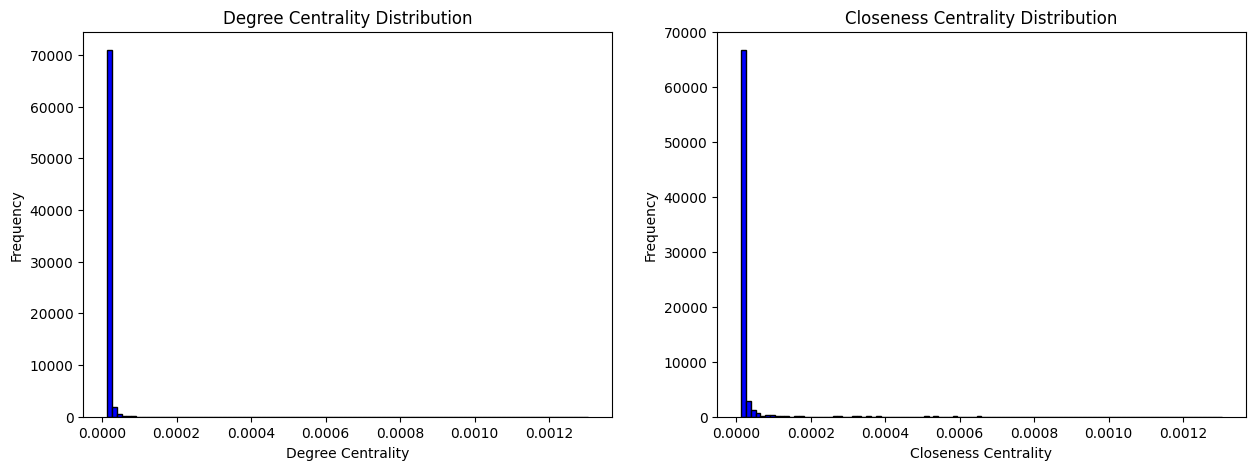

In [6]:
'''
3. Write a script that plots the degree centrality distribution and closeness centrality
distribution.
'''

def plot_degree_centrality(G):
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)


    # Plot degree centrality distribution and closeness centrality distribution
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].hist(degree_centrality.values(), bins=100, color='blue', edgecolor='black')
    ax[0].set_title("Degree Centrality Distribution")
    ax[0].set_xlabel("Degree Centrality")
    ax[0].set_ylabel("Frequency")

    ax[1].hist(closeness_centrality.values(), bins=100, color='blue', edgecolor='black')
    ax[1].set_title("Closeness Centrality Distribution")
    ax[1].set_xlabel("Closeness Centrality")
    ax[1].set_ylabel("Frequency")

    plt.show()

plot_degree_centrality(G)


In [19]:
'''
4. We want to test the extent to which the centrality distributions in 3) fit a power law
distribution. You may inspire from the implementation in powerlaw · PyPI of the power-law
distribution, or can use alternative one of your choice. It is important to quantify the
goodness of fit using p-value. Typically, when p-value is greater than 10%, we can state that
power-law is a plausible fit to the (distribution) data.

#TODO: check if this is correct
'''

def fit_power_law(G):
    # Calculate degree centrality and closeness centrality
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)

    # Fit the degree centrality distribution to a power-law distribution and compare with lognormal
    fit_degree = powerlaw.Fit(list(degree_centrality.values()))
    R, p = fit_degree.distribution_compare('power_law', 'lognormal')
    print(f"Degree Centrality: p-value = {p}")
    if p > 0.1:
        print("Power-law is a plausible fit to degree centrality data")
    else:
        print("Power-law is not a plausible fit to degree centrality data")

    # Fit the closeness centrality distribution to a power-law distribution and compare with lognormal
    fit_closeness = powerlaw.Fit(list(closeness_centrality.values()))
    R, p = fit_closeness.distribution_compare('power_law', 'lognormal')
    print(f"Closeness Centrality: p-value = {p}")
    if p > 0.1:
        print("Power-law is a plausible fit to closeness centrality data")
    else:
        print("Power-law is not a plausible fit to closeness centrality data")

fit_power_law(G)


Calculating best minimal value for power law fit
Degree Centrality: p-value = 0.0
Power-law is not a plausible fit to degree centrality data
Calculating best minimal value for power law fit
Closeness Centrality: p-value = 0.6496770099351223
Power-law is a plausible fit to closeness centrality data


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


In [8]:
'''
5. Write a script that calculates the number of triangles in the network. 

#TODO: check if this is correct
'''

def count_triangles(G):
    triangles = nx.triangles(G)
    print(f"Number of triangles: {sum(triangles.values())}")

count_triangles(G)

Number of triangles: 0


In [9]:
'''
6. Write a script that identifies the largest strongly connected component, second largest, third
'''
def find_strongly_connected_components(G):
    connected_components = sorted(nx.connected_components(G), key=len, reverse=True)
    for i, component in enumerate(connected_components):
        subgraph = G.subgraph(component)
        print(f"Strongly connected component {i+1} has {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges")
        if i == 2:
            break

find_strongly_connected_components(G)

Strongly connected component 1 has 97 nodes and 96 edges
Strongly connected component 2 has 87 nodes and 86 edges
Strongly connected component 3 has 79 nodes and 78 edges


In [11]:
'''
7. Write a script that calculates the shortest distance between any pair of the strongly
connected components in 5). Present the result in a table. Comment on the separability
between the above components.

TODO: check if this is correct
'''

def shortest_distance_between_components(G):
    shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))
    rows = []
    for node, lengths in shortest_path_lengths.items():
        for target_node, length in lengths.items():
            if target_node != node:
                row = pd.DataFrame({'Component 1': [node], 'Component 2': [target_node], 'Shortest Distance': [length]})
                rows.append(row)
    table = pd.concat(rows, ignore_index=True)
    print(table)

shortest_distance_between_components(G)


               Component 1         Component 2  Shortest Distance
0               1969527638          1969574754                  1
1               1969574754          1969527638                  1
2                 51878493            60789485                  1
3                 60789485            51878493                  1
4               1393409100            86868062                  1
...                    ...                 ...                ...
162031           323073788           177430436                  1
162032            20240488            86101271                  1
162033            86101271            20240488                  1
162034           946109466  759526036992208897                  1
162035  759526036992208897           946109466                  1

[162036 rows x 3 columns]


In [ ]:
'''
8. We want to identify relevant communities from the subnetwork graph corresponding to the
largest, second largest and third largest component. For this purpose, use Label propagation
algorithm implementation in NetworkX to identify the main communities. Write a script
that uses different color for each community and visualize the above graph with the detected
communities. Use the appropriate function in NetworkX to compute the separation among
the various communities and any other related quality measures. Comment on the quality of
the partition.

TODO: Write a script that uses different color for each community and visualize the above graph with the detected
    communities. Use the appropriate function in NetworkX to compute the separation among
    the various communities and any other related quality measures. Comment on the quality of
    the partition.
'''

def detect_communities(G):
    connected_components = sorted(nx.connected_components(G), key=len, reverse=True)
    for i, component in enumerate(connected_components):
        subgraph = G.subgraph(component)
        communities = nx.algorithms.community.asyn_lpa_communities(subgraph)
        community_map = {}
        for j, community in enumerate(communities):
            for node in community:
                community_map[node] = j
        colors = [community_map[node] for node in subgraph.nodes()]
        pos = nx.spring_layout(subgraph)
        plt.figure(figsize=(15, 9))
        nx.draw(subgraph, pos, node_color=colors, with_labels=False, node_size=10, edge_color='gray')
        plt.title(f"Strongly connected component {i+1}")
        plt.show()

        if i == 2:
            break

detect_communities(G)

In [ ]:
'''
9. We want to evaluate the evolution of the triangles (transitivity relation in the network). For
this purpose, we consider time increment as an accumulation of one thousand successive
rows in the original dataset. Suggest a script that calculates the evolution of the proportion
of triangles (number of triangles over the total number of nodes up to time t, basically t=1,
2,…,40), and draws the corresponding graph.

TODO: Does not work correctly
'''

def calculate_triangle_evolution(data):
    G = nx.Graph()
    triangles = []
    for i in range(0, len(data), 1000):
        for line in data[:i]:
            line = line.strip().split(',')
            id = line[0].strip('"').strip()
            friends = line[9][1:-1].split(', ')
            friends = [friend.replace('"', '').strip() for friend in friends]
            G.add_node(id)
            for friend in friends:
                G.add_edge(id, friend)
        triangles.append(sum(nx.triangles(G).values()))
    plt.plot(triangles)
    plt.xlabel("Time")
    plt.ylabel("Number of triangles")
    plt.show()

calculate_triangle_evolution(data)

In [ ]:
'''
10. From 9), write a script that identifies instances of triplet nodes A, B, C such at time t A is
connected to B and B is connected to C but A is not connected to C, while in time t+1, A
becomes connected to C. Check for theses instances whether the link prediction using
common neighbor (probability A being connected to C increases with the number of
common neighbours between A and B). Write the result in a table.

TODO: Does not work correctly
'''

def link_prediction():
    return



link_prediction()

In [ ]:
'''
11. Suggest appropriate literature to comment on the various findings and explore the limitation
of the reasoning pipeline.

TODO: 
'''